In [84]:
import collections
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
#載入影片資料
film = pd.read_csv('ml-100k/u.item', sep='|', encoding='ISO-8859-1')
film.columns = ['filmId', 'title', 'release date', 'video release date',
              'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
              'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
              'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
               'Sci-Fi', 'Thriller', 'War', 'Western']
columns = ['release date', 'video release date',
          'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
          'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
          'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
           'Sci-Fi', 'Thriller', 'War', 'Western']
film = film.drop(columns, axis=1)

In [180]:
def Start(data, test_data, user_id, input_k):
    data.columns = ['userId', 'filmId', 'rating', 'timestamp']
    test_data.columns = ['userId', 'filmId', 'rating', 'timestamp']
    data = data.drop(['timestamp'], axis=1)
    test_data.drop(['timestamp'], axis=1)
    #根據 filmId 和評分創建每個用戶的辭典
    watched = collections.defaultdict(dict)
    for i in data.values.tolist():
        watched[i[0]][i[1]] = i[2]
        
    # 創建一個數據表，row = userId，col = filmId，值為評分
    data_pivot = data.pivot(index='userId', columns = 'filmId',values='rating').fillna(0)
    # 轉換稀疏矩陣
    data_matrix = csr_matrix(data_pivot.values)
    
    knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    knn.fit(data_matrix)
    k = input_k
    
    user = user_id
    user_index = user - 1
    
    # 尋找最近的鄰居
    distances, indices = knn.kneighbors(data_pivot.iloc[user_index, :].values.reshape(1, -1), n_neighbors = k)
    # 使用者看過的影片
    user_watched = set(watched[data_pivot.index[user_index]])
    neighbours_watched = {}
    # 記錄下鄰居們和使用者的距離
    for i in range(0, len(distances.flatten())):
        neighbours_watched[data_pivot.index[indices.flatten()[i]]] = watched[data_pivot.index[indices.flatten()[i]]].copy()
        #儲存資料供之後的預測評分用
        for key, v in neighbours_watched[data_pivot.index[indices.flatten()[i]]].items():
            neighbours_watched[data_pivot.index[indices.flatten()[i]]][key] = [1 - distances.flatten()[i], v]
            
    unwatched_films = []
    for u in neighbours_watched:
        a = neighbours_watched[u].keys() - user_watched.intersection(neighbours_watched[u].keys())
        for f in a:
            unwatched_films.append(f)
    # 至少要有超過一個鄰居推薦，且還沒有看過的影片
    common_unwatched = [item for item, count in collections.Counter(unwatched_films).items() if count > 1]
    common_unwatched_rating = []
    #預測使用者會給的分數
    for f in common_unwatched:
        m = []
        w = []
        for u in neighbours_watched:
            if neighbours_watched[u].get(f) is not None:
                m.append(neighbours_watched[u].get(f)[0]*neighbours_watched[u].get(f)[1])
                w.append(neighbours_watched[u].get(f)[0])
        common_unwatched_rating.append([np.sum(m)/np.sum(w), f])
    common_unwatched_rating = sorted(common_unwatched_rating, reverse=True)
    
    #列出項目，計算分數準確率
    cur_user = (test_data['userId'] == user_id)
    valid_count = 0
    total_score = 0
    print('Top 10:')
    for f in common_unwatched_rating[:10]:
        whether_exist = (test_data[cur_user]['filmId'] == f[1])
        print('{0} - {1} - {2:.2f}'.format(f[1], film.loc[film['filmId'] == f[1]]['title'].values[0], f[0]))
        if(test_data[cur_user]['filmId'][whether_exist].empty):
            pass
            print('--no data')
        else:
            cur_user_rate = test_data[cur_user]['rating'][test_data[cur_user].index[whether_exist].tolist()[0]]
            # 1 - 誤差率等於準確率
            total_score += 1 - abs(cur_user_rate - f[0])/f[0]
            valid_count += 1
            print('--User ' + str(user_id) + ' rate the film as: ' + str(cur_user_rate))
    if(total_score == 0):
        return 0
    else:
        return total_score/valid_count

In [164]:
all_data = pd.read_csv('ml-100k/u.data', sep='\t', encoding='ISO-8859-1')
u1_base = pd.read_csv('ml-100k/u1.base', sep='\t', encoding='ISO-8859-1')
u2_base = pd.read_csv('ml-100k/u2.base', sep='\t', encoding='ISO-8859-1')
u3_base = pd.read_csv('ml-100k/u3.base', sep='\t', encoding='ISO-8859-1')
u4_base = pd.read_csv('ml-100k/u4.base', sep='\t', encoding='ISO-8859-1')
u5_base = pd.read_csv('ml-100k/u5.base', sep='\t', encoding='ISO-8859-1')
u1_test = pd.read_csv('ml-100k/u1.test', sep='\t', encoding='ISO-8859-1')
u2_test = pd.read_csv('ml-100k/u2.test', sep='\t', encoding='ISO-8859-1')
u3_test = pd.read_csv('ml-100k/u3.test', sep='\t', encoding='ISO-8859-1')
u4_test = pd.read_csv('ml-100k/u4.test', sep='\t', encoding='ISO-8859-1')
u5_test = pd.read_csv('ml-100k/u5.test', sep='\t', encoding='ISO-8859-1')

<font color=#ff0000>*定義計算分數的方式*</font>

選定 user 範圍 1 ~ 15， k 值則在 5 到 25 中尋找最佳解。  
計算分數的方式由推薦系統給的分數和實際該名 user 給的分數作對比。  
如果沒有資料就 pass，如果有資料就計算誤差比率，並記錄下預測準確率。

最後再 5 總train、test的分割方式中，取得平均，並找出最高分的做為預測用 K 值。

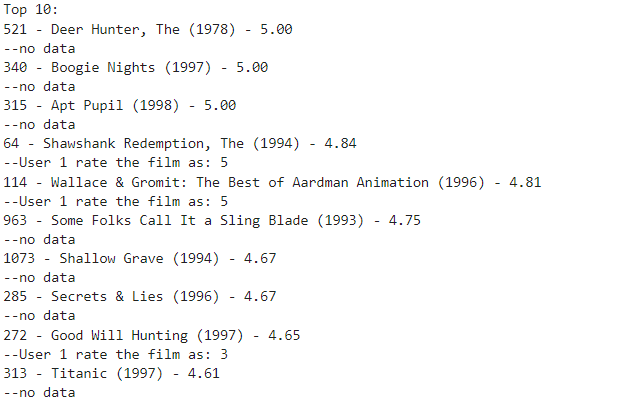

In [167]:
# 根據推薦出電影分數，與使用者於test中實際的評分
score1 = [0]*30
score2 = [0]*30
score3 = [0]*30
score4 = [0]*30
score5 = [0]*30

for userId in range(1, 15):
    for i in range(5, 25):
        result = Start(u1_base, u1_test, userId, i)
        if(result != 0):
            score1[i-5] = (score1[i-5] + result)/2
for userId in range(1, 15):
    for i in range(5, 25):
        result = Start(u2_base, u2_test, userId, i)
        if(result != 0):
            score2[i-5] = (score2[i-5] + result)/2
for userId in range(1, 15):
    for i in range(5, 25):
        result = Start(u3_base, u3_test, userId, i)
        if(result != 0):
            score3[i-5] = (score3[i-5] + result)/2
for userId in range(1, 15):
    for i in range(5, 25):
        result = Start(u4_base, u4_test, userId, i)
        if(result != 0):
            score4[i-5] = (score4[i-5] + result)/2
for userId in range(1, 15):
    for i in range(5, 25):
        result = Start(u5_base, u5_test, userId, i)
        if(result != 0):
            score5[i-5] = (score5[i-5] + result)/2

顯示各組 train、test 的計算出的分數結果

In [175]:
score1 = np.array(score1)
score2 = np.array(score2)
score3 = np.array(score3)
score4 = np.array(score4)
score5 = np.array(score5)
print(score1)
print(score2)
print(score3)
print(score4)
print(score5)

[0.87542634 0.82757397 0.85522358 0.88594116 0.85075532 0.8509556
 0.83926313 0.83927947 0.83512634 0.84371688 0.84498771 0.81214176
 0.88731661 0.88657233 0.72156905 0.72279474 0.88744039 0.89200579
 0.91952795 0.91990454 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.87464984 0.87080592 0.92573495 0.76028078 0.77089695 0.83171806
 0.8358167  0.80764651 0.79515455 0.7967657  0.80483242 0.87404698
 0.88256614 0.87945175 0.87767704 0.87991413 0.90292115 0.88860939
 0.89974984 0.77534777 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.94754624 0.94716364 0.89479335 0.94979768 0.90067314 0.80451292
 0.89893234 0.88104781 0.89468379 0.86746089 0.87549821 0.69126661
 0.69426687 0.89067484 0.89415326 0.89846422 0.90055519 0.87353658
 0.89155175 0.89365713 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.85324352 0.876

最後將各項成績加總平均，得到 K = 18 時的預測表現最好

In [176]:
mean_arr = (score1+score2+score3+score4+score5)/5
mean_arr

array([0.87969299, 0.87849665, 0.88956891, 0.87508001, 0.85577685,
       0.84796361, 0.87579348, 0.86025267, 0.86073123, 0.8547917 ,
       0.86091491, 0.82264973, 0.84732116, 0.88387684, 0.8564209 ,
       0.85334795, 0.8914242 , 0.88217608, 0.88349719, 0.83906484,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])